# SQL Alchemy Homework
## Date: 2020-05-09
### Written by: Skip Hobba
### Notes: The examples/answer keys given did not seem to be correct. 
### First, the measurements table has multiple dates, so you would be plotting and averaging over 2000 data points for a year. This would be okay, if we were looking at areas, but this is looking at Hawaii as a whole, so it skews the data. 
### Second, mid-2017 to mid - 2018 should be 365 days, the data includes 366 days. 2016 was a leap, year - but the dates do not strattle Feb 29th, so we should not include the extra day. 
### Third, not really an issue - but the most active station is the station with the mose temperature measurements. The wording of the question is a bit confusing as it implies there is another station. 


In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Using the inspector to print the column names within the 'measurements' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

Dates are from 2016-08-23 00:00:00 to 2017-08-23 00:00:00


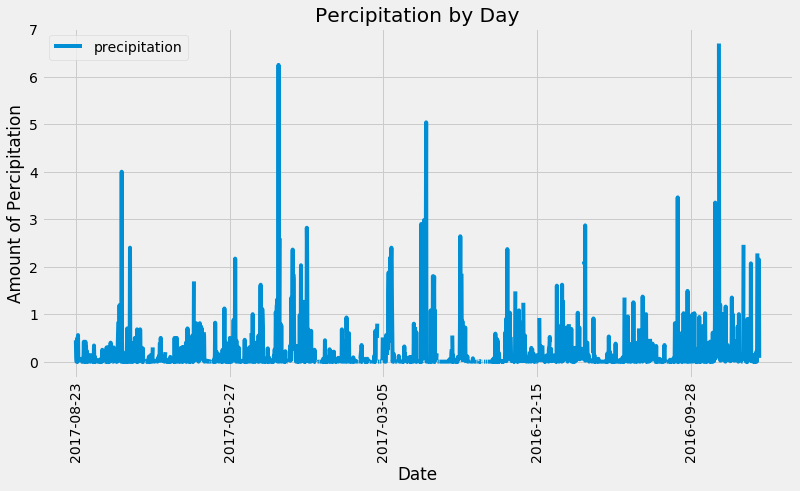

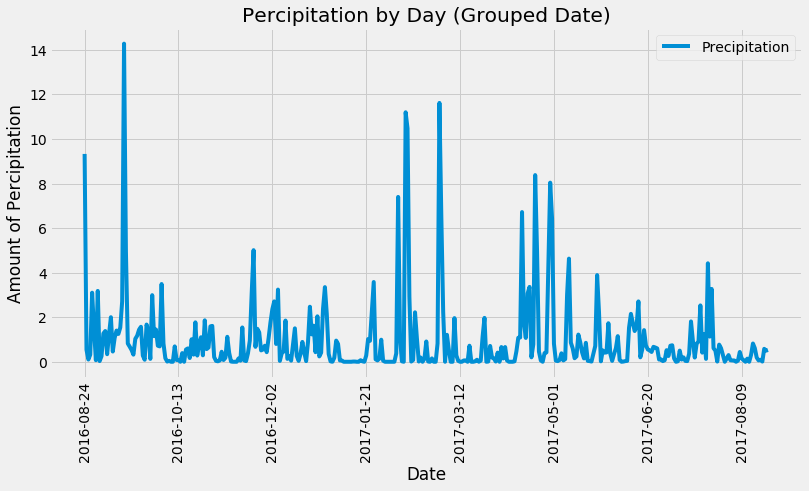

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
from dateutil.relativedelta import relativedelta
import datetime

max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
max_date = datetime.datetime.strptime(max_date, '%Y-%m-%d')
year_ago = max_date - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores
percip_data = session.query(Measurement.date, Measurement.prcp)\
              .filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
percip_df = pd.DataFrame(percip_data, columns=['date', 'precipitation'])
percip_df.set_index('date', inplace=True)

# Sort the dataframe by date
percip_df = percip_df.sort_values(by='date', ascending=False)

# Added as there was a lot of duplicate data due to multiple stations per date
#Generate a table based off date with a sum of parcipitation
percip_group = percip_df.groupby('date')

percip_date_df = pd.DataFrame({
            'Precipitation': percip_group['precipitation'].sum()
            })

# Use Pandas Plotting with Matplotlib to plot the data
print(f'Dates are from {year_ago} to {max_date}')

# Generate a bar plot showing number of data points for each treatment regimen using pyplot
ax = percip_df.plot(rot=90, figsize=(12,6));
ax.set_xlabel("Date")
ax.set_ylabel("Amount of Percipitation")
ax.set_title("Percipitation by Day")

plt.show()

# Generate a bar plot showing number of data points for each treatment regimen using pyplot
ax1 = percip_date_df.plot(rot=90, figsize=(12,6));
ax1.set_xlabel("Date")
ax1.set_ylabel("Amount of Percipitation")
ax1.set_title("Percipitation by Day (Grouped Date)")

plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print('Summary statistics for all data points, not grouped by date')
percip_df.describe()

Summary statistics for all data points, not grouped by date


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
print('Summary statistics grouped by date')
percip_date_df.describe()

Summary statistics grouped by date


,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
num_stations = engine.execute('SELECT count(station) FROM station').fetchall()
num_stations = num_stations[0][0]
print(f'There are {num_stations} used to analyze the weather.')

There are 9 used to analyze the weather.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = engine.execute('SELECT station, count(*) as count, count(prcp) as perc_measures, count (tobs) as temp_measures FROM measurement group by station order by 2 desc').fetchall()

for row in active_stations:
    print(row[0],' - ',row[1],' - ',row[2],' - ',row[3])

USC00519281  -  2772  -  2772  -  2772
USC00519397  -  2724  -  2685  -  2724
USC00513117  -  2709  -  2696  -  2709
USC00519523  -  2669  -  2572  -  2669
USC00516128  -  2612  -  2484  -  2612
USC00514830  -  2202  -  1937  -  2202
USC00511918  -  1979  -  1932  -  1979
USC00517948  -  1372  -  683  -  1372
USC00518838  -  511  -  342  -  511


In [18]:
active_stations2 = session.query(Measurement.station, func.count(Measurement.station))\
                   .group_by(Measurement.station)\
                   .order_by(func.count(Measurement.station).desc())

for row in active_stations2:
    print(row[0],' - ',row[1])

USC00519281  -  2772
USC00519397  -  2724
USC00513117  -  2709
USC00519523  -  2669
USC00516128  -  2612
USC00514830  -  2202
USC00511918  -  1979
USC00517948  -  1372
USC00518838  -  511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = session.query(Measurement.station, func.count(Measurement.station))\
                   .group_by(Measurement.station)\
                   .order_by(func.count(Measurement.station).desc()).first()

top_station = top_station[0]

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == top_station).scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == top_station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == top_station).scalar()

print(f'The most active station in the data set is {top_station}')
print(f'The minimum temperature recorded at {top_station} was {min_temp}.')
print(f'The maximum temperature recorded at {top_station} was {max_temp}.')
print(f'The average temperature recorded at {top_station} was {avg_temp}.')

The most active station in the data set is USC00519281
The minimum temperature recorded at USC00519281 was 54.0.
The maximum temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


The station with the most temperature measurement is USC00519281


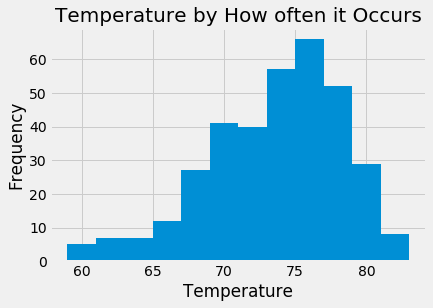

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_tobs_station = session.query(Measurement.station, func.count(Measurement.tobs))\
                   .group_by(Measurement.station)\
                   .order_by(func.count(Measurement.station).desc()).first()

top_tobs_station = top_tobs_station[0]

tobs_station_data = session.query(Measurement.date,Measurement.tobs)\
                    .filter(Measurement.station == top_tobs_station)\
                    .filter(Measurement.date >= year_ago).all()

tobs_station_df = pd.DataFrame(tobs_station_data, columns=['date', 'temperature'])

print(f'The station with the most temperature measurement is {top_tobs_station}')

plt.hist(tobs_station_df['temperature'], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature by How often it Occurs", fontsize = 20)
plt.show()

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps_trip = calc_temps('2015-09-21', '2015-10-02')
max_trip = temps_trip[0][2]
min_trip = temps_trip[0][0]
avg_trip = temps_trip[0][1]

print(f'Trip minimum temp {min_trip}, Trip maximum temp {max_trip}, Trip average temp {avg_trip}')

Trip minimum temp 71.0, Trip maximum temp 82.0, Trip average temp 77.4659090909091


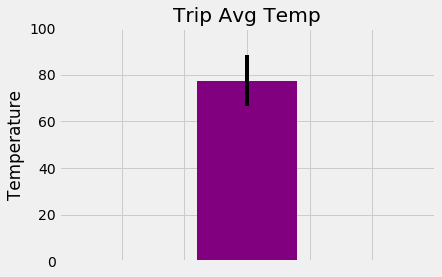

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_bar = 1
plt.bar(x_bar, avg_trip, color='Purple', yerr=max_trip-min_trip)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.ylim(0, 100)
plt.xlim(-.5, 2.5)
plt.tick_params(bottom=False,labelbottom=False)

plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2015-09-21'
end_date = '2015-10-02'
station_data = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp))\
              .outerjoin(Station, Measurement.station==Station.station)\
              .filter(Measurement.date >= start_date)\
              .filter(Measurement.date <= end_date)\
              .group_by(Measurement.station)\
              .order_by(func.sum(Measurement.prcp).desc())\
              .all()

station_data_df = pd.DataFrame(station_data, columns=['Station','Name','Lat','Long','Elev','Percip'])
station_data_df = station_data_df.sort_values(by='Percip', ascending=False)
station_data_df

,Station,Name,Lat,Long,Elev,Percip
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,14.69
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.50
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.67
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.57
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.70
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.62
6,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00
8,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
